1. Industry performance across regimes
1. Industry average weight across regimes (need results for this)
1. Regimes probabilities across time
1. Performance of the three factors across regimes

In [62]:
import pandas as pd
from regimeaware.routines import cfg
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
from sklearn import preprocessing
from hmmlearn.hmm import GaussianHMM
from matplotlib.ticker import StrMethodFormatter
from matplotlib.lines import Line2D
from matplotlib.ticker import AutoMinorLocator
from scipy import interpolate
import seaborn as sns
from scipy.stats import norm, kstest

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["CMU Serif"]
})

dpi = 300
width = 7.5
height = 4.5

# Make sure the alignment while optimizing is correct 

In [63]:
import os

fldr = r"D:\My Drive\bin\regimeaware\data\results\exp_10"
flist = os.listdir(fldr)

collector = []
for fname in flist:
    collector += [pd.read_pickle(f"{fldr}/{fname}")]

wt = pd.concat(collector)
wt = wt.div(wt.abs().groupby('date').sum()).mul(2)
wt.sort_index(inplace=True)

<Axes: xlabel='date'>

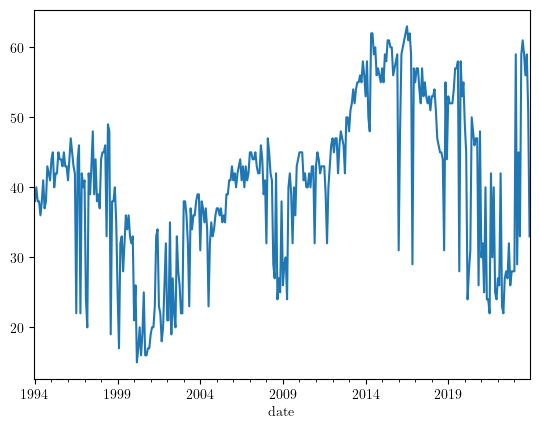

In [64]:
(wt.groupby('date').count() - wt.where(np.isclose(wt.abs(), 0, atol=5e-5)).groupby('date').count()).plot()

In [65]:
rt = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')['ret']

<Axes: xlabel='date'>

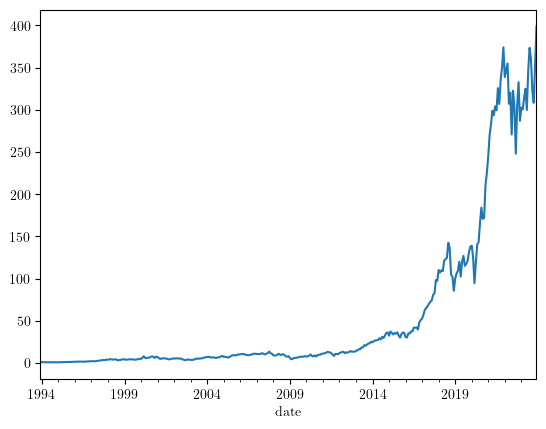

In [66]:
aa = wt.groupby('permno').shift(1).mul(rt.loc[cfg.bt_start_dt:]).groupby('date').sum()
aa.add(1).cumprod().plot()

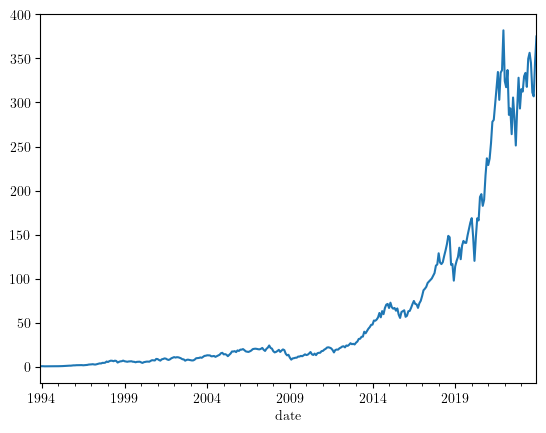

<Axes: xlabel='date'>

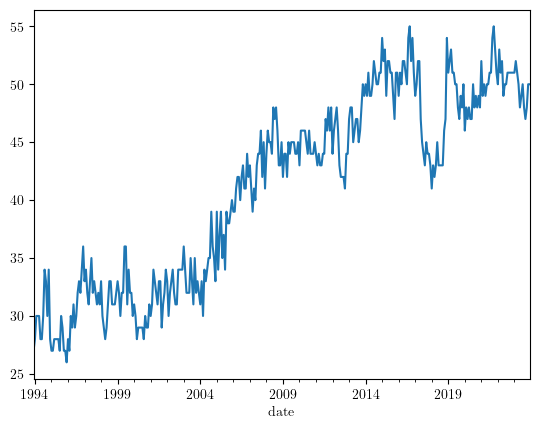

In [67]:
fldr = r"D:\My Drive\bin\regimeaware\data\results\ols_10"
flist = os.listdir(fldr)

collector = []
for fname in flist:
    collector += [pd.read_pickle(f"{fldr}/{fname}")]

wt = pd.concat(collector)
wt = wt.div(wt.abs().groupby('date').sum()).mul(2)
wt.sort_index(inplace=True)

bb = wt.groupby('permno').shift(1).mul(rt.loc[cfg.bt_start_dt:]).groupby('date').sum()
bb.add(1).cumprod().plot()

plt.show()
wt[~np.isclose(wt, 0, atol=1e-5)].groupby('date').count().plot()

In [68]:
# fldr = r"D:\My Drive\bin\regimeaware\data\results\mvo_75"
# flist = os.listdir(fldr)

# collector = []
# for fname in flist:
#     collector += [pd.read_pickle(f"{fldr}/{fname}")]

# wt = pd.concat(collector)
# wt = wt.div(wt.abs().groupby('date').sum()).mul(2)
# wt.sort_index(inplace=True)

# cc = wt.groupby('permno').shift(1).mul(rt.loc[cfg.bt_start_dt:]).groupby('date').sum()
# cc.add(1).cumprod().plot()

# plt.show()
# wt[~np.isclose(wt, 0, atol=1e-5)].groupby('date').count().plot()

<Axes: xlabel='date'>

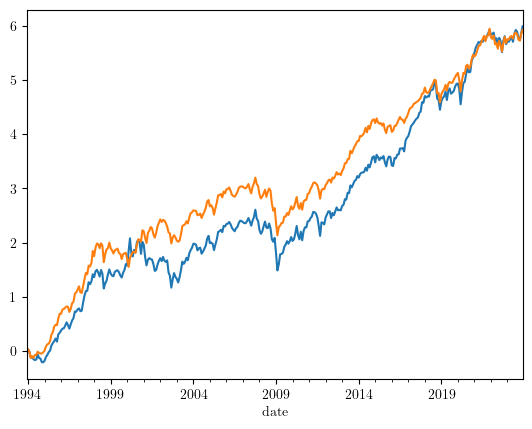

In [69]:
aa.add(1).cumprod().apply(np.log).plot()
bb.add(1).cumprod().apply(np.log).plot()
# cc.add(1).cumprod().apply(np.log).plot()

In [70]:
print(aa.mean() / aa.std() * np.sqrt(12))
print(bb.mean() / bb.std() * np.sqrt(12))

0.7759644368640112
0.8413527845711938


In [71]:
from scipy import stats
stats.ks_2samp(aa.loc['2003':], cc.loc['2003':], alternative='less').pvalue

0.0008949824933482338

In [72]:
import numpy as np
import matplotlib.pyplot as plt

from hmmlearn import hmm

# Prepare parameters for a 4-components HMM
# Initial population probability
startprob = np.array([0.6, 0.3, 0.1, 0.0])
# The transition matrix, note that there are no transitions possible
# between component 1 and 3
transmat = np.array([[0.7, 0.2, 0.0, 0.1],
                     [0.3, 0.5, 0.2, 0.0],
                     [0.0, 0.3, 0.5, 0.2],
                     [0.2, 0.0, 0.2, 0.6]])
# The means of each component
means = np.array([[0.0, 0.0],
                  [0.0, 11.0],
                  [9.0, 10.0],
                  [11.0, -1.0]])
# The covariance of each component
covars = .5 * np.tile(np.identity(2), (4, 1, 1))

# Build an HMM instance and set parameters
gen_model = hmm.GaussianHMM(n_components=4, covariance_type="full")

# Instead of fitting it from the data, we directly set the estimated
# parameters, the means and covariance of the components
gen_model.startprob_ = startprob
gen_model.transmat_ = transmat
gen_model.means_ = means
gen_model.covars_ = covars

# Generate samples
X, Z = gen_model.sample(500)

In [73]:
covars

array([[[0.5, 0. ],
        [0. , 0.5]],

       [[0.5, 0. ],
        [0. , 0.5]],

       [[0.5, 0. ],
        [0. , 0.5]],

       [[0.5, 0. ],
        [0. , 0.5]]])

In [74]:
X.shape

(500, 2)

In [75]:
pd.DataFrame(X)

,0,1
0,8.620737,8.863433
1,-1.321826,9.365546
2,-0.030380,-0.272015
3,10.740104,-1.474594
4,11.259805,-1.535431
...,...,...
495,7.421061,10.951091
496,0.343300,11.325670
497,0.445972,0.505836
498,0.116520,0.220377


In [83]:
emission_prob = pd.read_pickle(f"{cfg.data_fldr}/regimes/emission_prob.pkl")
transition_matrix = pd.read_pickle(f"{cfg.data_fldr}/regimes/transmat.pkl")
mu_f = pd.read_pickle(f"{cfg.data_fldr}/regimes/mu.pkl")
sigma_f = pd.read_pickle(f"{cfg.data_fldr}/regimes/sigma.pkl")
mktcap = pd.read_pickle(f'{cfg.data_fldr}/mktcap.pkl')
is_tradable = pd.read_pickle(f'{cfg.data_fldr}/is_tradable.pkl')
sector = pd.read_pickle(f'{cfg.data_fldr}/gics_mapping.pkl')['sector']

# Load cached factor estimates
factor_covars = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_covars.pkl')
factor_means = pd.read_pickle(f'{cfg.data_fldr}/moments/factor_means.pkl')
factor_loadings = pd.read_pickle(f'{cfg.data_fldr}/exposures/forecasted_betas.pkl')
factor_variance = pd.read_pickle(f'{cfg.data_fldr}/exposures/var.pkl')

# Excess returns
rt = pd.read_pickle(f'{cfg.data_fldr}/crsp.pkl')[['ret']]
ff = pd.read_pickle(f'{cfg.data_fldr}/ff.pkl').sort_index()
rf = ff['rf']
ff = ff[cfg.factor_set + ['umd']]
rt = rt.sub(rf, axis=0).dropna(how='all')

vix = pd.read_pickle(f"{cfg.data_fldr}/vix.pkl")

rec_flag = pd.read_pickle(f"{cfg.data_fldr}/rec_flag.pkl")
rec_flag = rec_flag.astype(bool).reindex(rt.index)

## Determining the number of states

c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: 

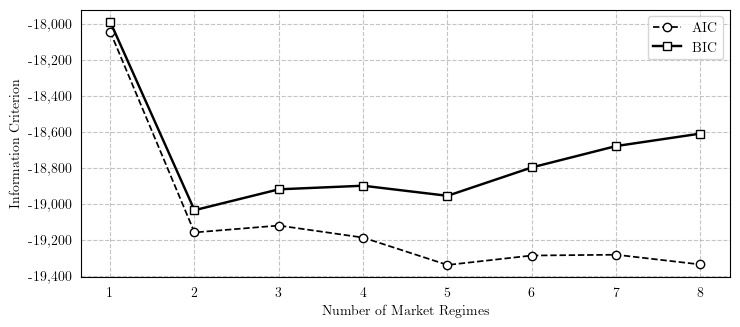

In [107]:
states_to_try = range(1, 9)

bic = pd.Series(index=states_to_try, dtype=float)
aic = pd.Series(index=states_to_try, dtype=float)
# trn = ff.loc[cfg.trn_start_dt:cfg.bt_start_dt].copy()
trn = ff.loc[cfg.trn_start_dt:cfg.bt_end_dt].copy()

for n in states_to_try:
    mdl = GaussianHMM(
        n_components=n,
        covariance_type="diag",
        # random_state=cfg.hm_rs,
        random_state=321,
        min_covar=cfg.hm_min_covar,
        tol=cfg.hm_tol
    )
    mdl.fit(trn)
    bic[n] = mdl.bic(trn)
    aic[n] = mdl.aic(trn)

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(width, height * .75), sharex=True, sharey=False)
plot_map = {'AIC': (aic, '--', 1.25, 'o'), 'BIC': (bic, '-', 1.75, 's')}

for label, params in plot_map.items():
    ax.plot(params[0], color='k', marker=params[3], mfc='white', lw=params[2], ls=params[1])
    ax.grid(ls='--', alpha=.75)

# ax.set_title('Information Criterion', weight='bold')
ax.set_ylabel('Information Criterion')
ax.set_xlabel('Number of Market Regimes')
ax.legend(['AIC', 'BIC'])
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.tick_params(axis='both', bottom=False, left=False)
plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/state_calibration.pdf", dpi=dpi, transparent=True)
plt.show()


## Market regimes smoothed probabilities

In [91]:
trn

,mktrf,smb,hml,rmw,cma,umd
date,,,,,,
1963-07-31,-0.0039,-0.0041,-0.0097,0.0068,-0.0118,0.0090
1963-08-31,0.0507,-0.0080,0.0180,0.0036,-0.0035,0.0101
1963-09-30,-0.0157,-0.0052,0.0013,-0.0071,0.0029,0.0019
1963-10-31,0.0253,-0.0139,-0.0010,0.0280,-0.0201,0.0312
1963-11-30,-0.0085,-0.0088,0.0175,-0.0051,0.0224,-0.0074
...,...,...,...,...,...,...
2023-08-31,-0.0239,-0.0368,-0.0108,0.0342,-0.0237,0.0377
2023-09-30,-0.0524,-0.0179,0.0145,0.0185,-0.0084,0.0024
2023-10-31,-0.0318,-0.0405,0.0019,0.0247,-0.0067,0.0168


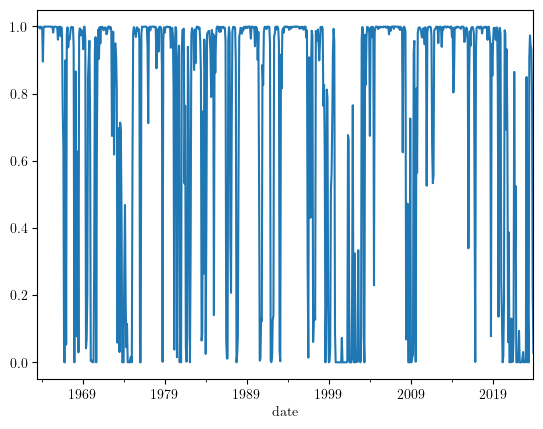

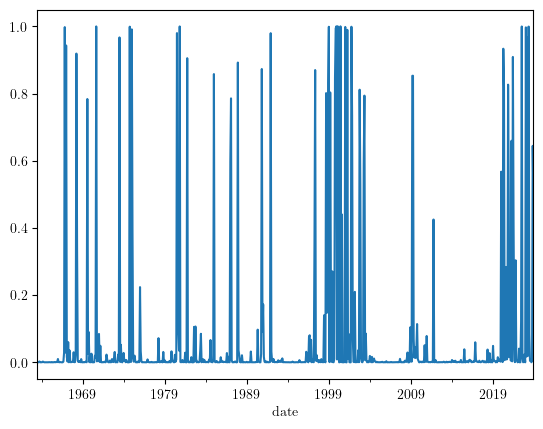

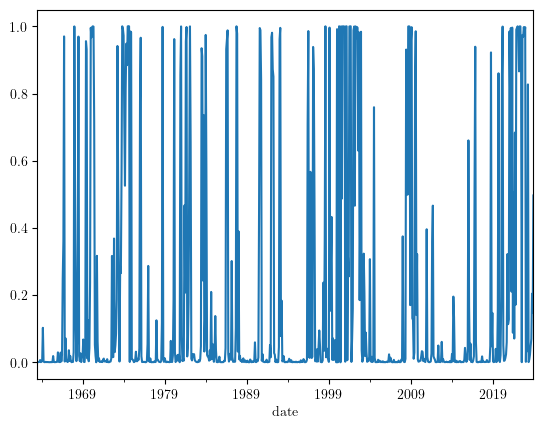

In [92]:
emission_prob = pd.read_pickle(f"{cfg.data_fldr}/regimes/emission_prob.pkl").xs(cfg.bt_end_dt)
emission_prob[0].plot()
plt.show()
emission_prob[1].plot()
plt.show()
emission_prob[2].plot()
plt.show()

In [96]:
trn.tail()

,mktrf,smb,hml,rmw,cma,umd
date,,,,,,
2023-08-31,-0.0239,-0.0368,-0.0108,0.0342,-0.0237,0.0377
2023-09-30,-0.0524,-0.0179,0.0145,0.0185,-0.0084,0.0024
2023-10-31,-0.0318,-0.0405,0.0019,0.0247,-0.0067,0.0168
2023-11-30,0.0883,-0.0011,0.0166,-0.0381,-0.0099,0.0276
2023-12-31,0.0487,0.0733,0.0492,-0.0304,0.0130,-0.0548


c:\Users\franc\miniconda3\envs\research\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


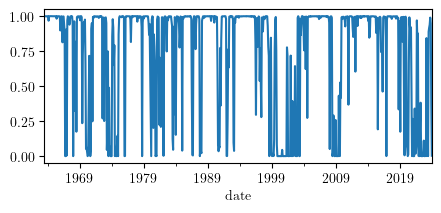

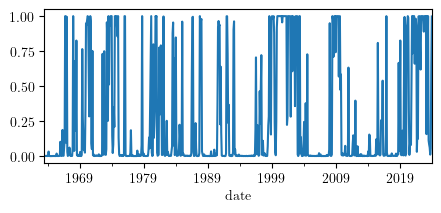

      mktrf       smb      hml       rmw       cma       umd
0  0.109351  0.030293  0.00051  0.036427  0.002418  0.114786
1 -0.053798  0.012175  0.13743  0.027169  0.122351 -0.055315
[0.11803518 0.0815246  0.06853106 0.04986749 0.05134227 0.0861918 ]
[0.23328217 0.15898982 0.16978752 0.13211795 0.11449319 0.2486518 ]
[[0.8916107  0.1083893 ]
 [0.31737703 0.68262297]]


In [103]:
trn = ff.loc[cfg.trn_start_dt:cfg.bt_end_dt]

mdl = GaussianHMM(
    n_components=2,
    covariance_type=cfg.hm_cov,
    random_state=cfg.hm_rs,
    n_iter=cfg.hm_iter,
    min_covar=cfg.hm_min_covar,
    tol=cfg.hm_tol
)
mdl.fit(trn)

df = pd.DataFrame(mdl.predict_proba(X=trn), index=trn.index)
for x in df:
    df[x].plot(figsize=(5, 2))
    plt.show()

mu_t = pd.DataFrame(mdl.means_, columns=trn.columns)
print(pd.DataFrame(mu_t) * 12)
[print(np.sqrt(np.diag(x) * 12)) for x in mdl.covars_]
print(mdl.transmat_)

In [100]:
trn.tail()

,mktrf,smb,hml,rmw,cma,umd
date,,,,,,
2023-08-31,-0.0239,-0.0368,-0.0108,0.0342,-0.0237,0.0377
2023-09-30,-0.0524,-0.0179,0.0145,0.0185,-0.0084,0.0024
2023-10-31,-0.0318,-0.0405,0.0019,0.0247,-0.0067,0.0168
2023-11-30,0.0883,-0.0011,0.0166,-0.0381,-0.0099,0.0276
2023-12-31,0.0487,0.0733,0.0492,-0.0304,0.0130,-0.0548


In [63]:
state_order = [2, 0, 3, 1]
regime_map = {
    2: "Market Regime 1: Bull",
    0: "Market Regime 2: Greed",
    3: "Market Regime 3: Fear",
    1: "Market Regime 4: Bear",
}

In [ ]:
cmap = ['forestgreen', 'yellowgreen', 'darkorange', 'firebrick']
# cmap = mpl.colormaps['RdYlGn_r'].resampled(4)
# cmap = [cmap(x) for x in range(4)]
fig, axs = plt.subplots(nrows=emission_prob.shape[1], figsize=(width, height), sharex=True)
data = emission_prob.xs(emission_prob.index.get_level_values('as_of')[-1])
# data = data[state_order]
# data.columns = range(len(state_order))
for i, ax in enumerate(axs):
    m = state_order[i]
    ts = data[m]
    ax.plot(ts, color=cmap[i], lw=1.25)
    ax.fill_between(ts.index, ts, color=cmap[i], alpha=.25)
    ax.set_title(regime_map[m])
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_yticks([0, .5, 1])
    ax.grid(ls='--', lw=.75)
    ax.set_ylim(0, 1)
    ax.set_xlim(ts.index[0], ts.index[-1])

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/emission_prob.pdf", dpi=dpi, transparent=True)
plt.show()

In [ ]:
B = transition_matrix.xs(transition_matrix.index.get_level_values('as_of')[-1])
B = pd.DataFrame(np.linalg.matrix_power(B, 4))
# B.reindex(state_order).reindex(state_order, axis=1).round(2)
B.round(2)

In [ ]:
mu_f.xs(mu_f.index.get_level_values('as_of')[-1]).mul(52).T

In [ ]:
S = sigma_f.xs(sigma_f.index.get_level_values('as_of')[-1])
S = pd.DataFrame.from_dict({x: pd.Series(np.diag(S.xs(x)), index=sigma_f.columns) for x in range(4)})
S = S.mul(52).apply(np.sqrt)
S

In [ ]:
X = mu_f.xs(mu_f.index.get_level_values('as_of')[-1]).mul(52).T
X = X[state_order]
X.index.name = 'factor'
X.rename(regime_map, axis=1, inplace=True)

S = sigma_f.xs(sigma_f.index.get_level_values('as_of')[-1])
S = pd.DataFrame.from_dict({x: pd.Series(np.diag(S.xs(x)), index=sigma_f.columns) for x in range(4)})
S = S.mul(52).apply(np.sqrt)
S = S[state_order]
S.index.name = 'factor'
S.columns.name = 'state'
S.rename(regime_map, axis=1, inplace=True)


factor_labels = {
    'mktrf': 'Mkt',
    'smb': 'SMB', 
    'hml': 'HML', 
    'rmw': 'RMW', 
    'cma': 'CMA'
}
sorting_y = ['cma', 'rmw', 'hml', 'smb', 'mktrf']

fig, axs = plt.subplots(ncols=2, figsize=(width, height * .6), sharex=False, sharey=True)
for i, col in enumerate(X.columns):
    axs[0].scatter(y=range(X.shape[0]), x=X.loc[sorting_y, col].values, color=cmap[i], zorder=25, s=60, marker='s', alpha=.75)
    axs[1].scatter(y=range(X.shape[0]), x=S.loc[sorting_y, col].values, color=cmap[i], zorder=25, s=60, marker='s', alpha=.75)


for ax in axs:
    ax.set_yticks(range(5))
    ax.set_yticklabels([factor_labels[x] for x in sorting_y])
    ax.grid(ls='--', zorder=-25, lw=.75, alpha=.5)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.tick_params(axis='both', bottom=False, left=False)

axs[0].set_title('Factor Expected Return')
axs[1].set_title('Factor Volatility')
axs[0].set_xlabel('$\mu$', fontsize=12)
axs[1].set_xlabel('$\sigma$', fontsize=12)

lgd = fig.legend([f'Market Regime {x + 1}' for x in range(4)], ncol=4, loc="lower center", bbox_to_anchor=(0.5, -0.1))
axs[0].axvline(0, c='gray', lw=1, zorder=10)

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/mu_sigma_factors.pdf", dpi=dpi, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

In [ ]:
X_long = X.melt(ignore_index=False).reset_index().set_index(['factor', 'state']).sort_index().loc[cfg.factor_set].squeeze()
S_long = S.melt(ignore_index=False).reset_index().set_index(['factor', 'state']).sort_index().loc[cfg.factor_set].squeeze()

fig, axs = plt.subplots(nrows=5, ncols=4, figsize=(width, height), sharex=True, sharey='row')
x_axis = np.arange(-1, 1, 0.001)
cmap_dict = dict(zip(S.columns, cmap))

for labels, ax in zip(S_long.index, axs.flatten()):
    dist_vals = norm.pdf(x_axis, X.loc[labels], S.loc[labels])
    dist_vals = dist_vals / sum(dist_vals)
    ax.plot(x_axis, dist_vals, color=cmap_dict[labels[1]], zorder=25, lw=1)
    ax.fill_betweenx(dist_vals, x_axis, color=cmap_dict[labels[1]], alpha=.15, zorder=20)
    ax.set_ylim((0, ax.get_ylim()[1]))
    ax.grid(ls='--', zorder=-25, lw=.75, alpha=.5)
    ax.axvline(x=X.loc[labels], ymin=0, ymax=max(dist_vals) / ax.get_ylim()[1], zorder=10, color=cmap_dict[labels[1]], lw=1, ls='-')
    ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.tick_params(axis='both', bottom=False, left=False)
    ax.set_xlim(-.5, .5)
    ax.set_xticks([-.25, 0, .25])
    ax.set_yticks([])

for i, state in enumerate(X.columns):
    axs[0, i].set_title(state.replace(':', ':\n'))

for i, factor in enumerate(cfg.factor_set):
    axs[i, 0].set_ylabel(factor_labels[factor])


# fig.subplots_adjust(wspace=0.2)

plt.tight_layout()
fig.subplots_adjust(wspace=0.1, hspace=0)
plt.savefig(f"{cfg.fldr}/img/state_dist_factors.pdf", dpi=dpi, bbox_inches='tight')
plt.show()

## Sectors vs. Recessions

In [8]:
rt_long = rt.melt(ignore_index=False).reset_index().set_index(['date', 'permno']).squeeze().dropna().sort_index()

obs_dates = rt_long.index.get_level_values('date').unique()
mcap_dates = mktcap.index.get_level_values('date').unique()
dt_mapping = {mcap_dates.asof(x): x for x in obs_dates}
mktcap_mnth = mktcap.loc[dt_mapping.keys()]
mktcap_mnth.rename(dt_mapping, inplace=True)

sector_size = mktcap_mnth.to_frame('sector_size').join(sector).groupby(['date', 'sector']).sum()
df_mcap = mktcap_mnth.to_frame('market_cap').join(sector).dropna()
df_mcap = df_mcap.join(sector_size, on=['date', 'sector'])
sector_wts = df_mcap['market_cap'].div(df_mcap['sector_size'])
sector_wts_flat = pd.pivot_table(sector_wts.to_frame('weight').join(sector), index=['date', 'permno'], values='weight', columns='sector')
sector_rt = sector_wts_flat.groupby(['permno']).shift(1).mul(rt_long, axis=0).dropna(how='all').groupby('date').sum()

In [ ]:
defensive_names = ['Utilities', 'Consumer Staples', 'Health Care']
cyclical_names = ['Materials', 'Consumer Discretionary', 'Financials']

sector_xs = sector_rt.sub(ff['rf'], axis=0).sub(ff['mktrf'], axis=0).dropna()
sector_xs = sector_xs.div(sector_xs.std())

df = sector_xs.melt(ignore_index=False)
df.loc[df['sector'].isin(cyclical_names), 'Sector'] = 'Cyclical'
df.loc[df['sector'].isin(defensive_names), 'Sector'] = 'Defensive'
df = df.join(rec_flag.rename('USREC'))
df.dropna(inplace=True)

fig, axs = plt.subplots(figsize=(width, height *.8), ncols=2, sharey=True, sharex=True)
sns.kdeplot(data=df[~df['USREC']], x="value", hue="Sector", palette=['midnightblue', 'firebrick'], lw=1.75, cumulative=True, common_norm=False, common_grid=True, ax=axs[0], zorder=25, legend=None)
sns.kdeplot(data=df[df['USREC']], x="value", hue="Sector", palette=['midnightblue', 'firebrick'], cumulative=True, common_norm=False, common_grid=True, ax=axs[1], zorder=25, legend=None)
axs[0].set_xlim(-3, 3)
axs[0].set_ylim(0, 1)

axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0].tick_params(axis='both', bottom=False, left=False)

axs[0].set_title('Expansion')
axs[1].set_title('Recession')

for i in range(2):
    axs[i].set_xlabel("Excess Return ($\sigma$)")
    axs[i].grid(ls='--', zorder=-25)
    axs[i].tick_params(axis='both', bottom=False, left=False)

lgd = fig.legend(['Defensive Sectors', 'Cyclical Sectors'], loc='lower center', ncols=2, bbox_to_anchor=(.5, -.075))

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/kde_rec.pdf", dpi=dpi, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

sample_a = sector_xs.loc[rec_flag, defensive_names].melt()['value']
sample_b = sector_xs.loc[rec_flag, cyclical_names].melt()['value']
print(kstest(sample_a, sample_b, alternative='less', method='asymp'))

In [ ]:
sector_xs = sector_rt.copy()

df = sector_xs.melt(ignore_index=False)
df.loc[df['sector'].isin(cyclical_names), 'Sector'] = 'Cyclical'
df.loc[df['sector'].isin(defensive_names), 'Sector'] = 'Defensive'
df = df.join(rec_flag.rename('USREC'))
df.dropna(inplace=True)

vix_m = vix.resample('M').last().rename('VIXCLS')
df1 = sector_xs[defensive_names].mean(axis=1).sub(sector_xs[cyclical_names].mean(axis=1)).to_frame('ret').join(vix_m).dropna()

bw_p = .7
fig, ax = plt.subplots(figsize=(width, height))
sns.kdeplot(x='VIXCLS', y='ret', bw_adjust=bw_p, ax=ax, data=df1, fill=True, zorder=52, cmap=sns.color_palette("Blues", as_cmap=True), alpha=.95)
sns.kdeplot(x='VIXCLS', y='ret', bw_adjust=bw_p, ax=ax, data=df1, fill=False, zorder=55, color='black', linewidths=.25, alpha=.5)
ax.tick_params(left=False, bottom=False)
ax.grid(ls='--', zorder=-25, alpha=.75, axis='y')
ax.axhline(0, color='black', zorder=50, lw=1.5)
ax.set_ylim(-.125, .125)
ax.set_xlim(5, 60)

q_list = [.01, .25, .5, .75, .99]
for q in q_list:
    loc = vix_m.reindex(sector_xs.index).quantile(q)
    
    if q == .01:
        txt = '$1^{st}$'
    else:
        txt = f'${round(q * 100)}^{{th}}$'
    ax.axvline(loc, color='black', lw=1, zorder=99, ls='--')
    ax.text(loc, y=.105, zorder=99, s=txt, ha='center', va='center', bbox={'boxstyle': 'round, pad=.3', 'fc': 'navajowhite', 'alpha': 1, 'ec': 'gray'})

ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.set_xlabel('VIX')
ax.set_ylabel('Return Spread Between Defensive and Cyclical Sectors')
ax.set_xticks(vix_m.quantile(q_list))
ax.set_xticklabels(vix_m.quantile(q_list).round(1))

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/joint_vix.pdf", dpi=dpi, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

In [11]:
rec_start_dt = rec_flag[rec_flag.astype(int).diff() == 1]
rec_end_dt = rec_flag[rec_flag.astype(int).diff() == -1]

In [ ]:
np.round((rec_end_dt.index - rec_start_dt.index).days / 30)

In [ ]:
np.mean(np.round((rec_end_dt.index - rec_start_dt.index).days / 30))

## Backtest figs

In [14]:
bt_wts = pd.read_pickle(f'{cfg.data_fldr}/results/sector_trackingerror_wts.pkl')
bt_wts.rename({x: round(x, 3) for x in bt_wts.index.get_level_values('tev').unique()}, inplace=True)
rt_ext = rt.reindex(bt_wts.index.get_level_values('date'))[bt_wts.columns]
rt_ext.index = bt_wts.index
bt_rt = bt_wts.groupby('tev').shift(1).mul(rt_ext).sum(axis=1)
rebalance_dates = factor_loadings.index.get_level_values('date').unique()
crsp_dates = mktcap.index.get_level_values('date').unique()
mktcap_eom = mktcap_mnth.rename({crsp_dates.asof(x): x for x in rebalance_dates})
total_mktcap = mktcap_eom.reindex(is_tradable.index).groupby('date').sum()
mktcap_wts = mktcap_eom.div(total_mktcap)
bm_rt = mktcap_wts.groupby('permno').shift(1).mul(rt_long).dropna().groupby('date').sum()
bt_rt_flat = pd.pivot_table(bt_rt.to_frame('rt'), index='date', columns='tev', values='rt')
rt_flat = bt_rt_flat.join(bm_rt.rename('vw')).dropna()
tracking = rt_flat.sub(rt_flat['vw'], axis=0).drop('vw', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = rt_flat.mean().div(rt_flat.std()).mul(np.sqrt(12))

In [ ]:
raw = ir[[.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]].copy()
x = list(raw.index)
y = raw.astype(float).values
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.arange(.01, .10, .001)
ir_smoothed = pd.Series(f(x_new), index=x_new)

fig, ax = plt.subplots(figsize=(width, height * .6))
ax.plot(ir_smoothed[.02:.08], color='black', lw=1.25, zorder=25)
ax.grid(ls='--', alpha=.75, zorder=-25)
ax.set_xlabel('Tracking Error Budget')
ax.set_ylabel('Information Ratio')
ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
ax.tick_params(axis='both', bottom=False, left=False)

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/ir_tev.pdf", dpi=dpi, transparent=True)
plt.show()

In [ ]:
# MSCI classification
defensive_names = ['Utilities', 'Consumer Staples', 'Health Care']
cyclical_names = ['Materials', 'Consumer Discretionary', 'Financials', 'Real Estate', 'Communication Services', 'Information Technology', 'Industrials']

defensive_ids = sector[sector.isin(defensive_names)].index
cyclical_ids = sector[sector.isin(cyclical_names)].index

tev = .04

wts_defensive = bt_wts.xs(tev).loc[:, bt_wts.columns.isin(defensive_ids)].sum(axis=1)
wts_cyclical = bt_wts.xs(tev).loc[:, bt_wts.columns.isin(cyclical_ids)].sum(axis=1)

wts_rotation = pd.concat([wts_cyclical, (1 - wts_cyclical - wts_defensive).round(4), wts_defensive], axis=1)
wts_rotation.columns = ['Cyclical', 'Neutral', 'Defensive']

bear_state_sel = pd.pivot_table(mu_f['mktrf'].to_frame(), index='as_of', columns='state', values='mktrf').idxmin(axis=1)
idx = pd.MultiIndex.from_tuples(bear_state_sel.items(), names=['as_of', 'state'])

filtered_prob = emission_prob.groupby('as_of').last()
filtered_prob = filtered_prob.melt(var_name='state', ignore_index=False).reset_index().set_index(['as_of', 'state']).sort_index().squeeze()
bear_filtered_prob = filtered_prob.reindex(idx).droplevel('state')

fig, axs = plt.subplots(nrows=2, figsize=(width, height * .75), sharex=True, sharey=False)
axs[0].plot(wts_rotation['Defensive']['2003':].resample('Q').mean(), color='black', lw=1)
axs[0].grid(ls='--')
axs[1].grid(ls='--')
axs[1].plot(bear_filtered_prob['2003':].resample('Q').mean(), color='black', lw=1)
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[0].tick_params(axis='both', bottom=False, left=False)
axs[0].set_ylabel("Portfolio Weight")
axs[1].set_ylabel("Filtered Probability")
axs[1].tick_params(axis='both', bottom=False, left=False)
axs[0].set_title('Allocation to Defensive Stocks Across Rebalances')
axs[1].set_title('Bear Market Regime Emission Probabilities')

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/defensive_allocation.pdf", dpi=dpi, transparent=True, bbox_extra_artists=[lgd], bbox_inches='tight')
plt.show()

In [19]:
bt_wts = pd.read_pickle(f'{cfg.data_fldr}/results/sn_riskaversion_wts.pkl')
bt_wts.rename({x: round(x, 3) for x in bt_wts.index.get_level_values('gamma').unique()}, inplace=True)
rt_ext = rt.reindex(bt_wts.index.get_level_values('date'))[bt_wts.columns]
rt_ext.index = bt_wts.index
bt_rt = bt_wts.groupby('gamma').shift(1).mul(rt_ext).sum(axis=1)
rebalance_dates = factor_loadings.index.get_level_values('date').unique()
crsp_dates = mktcap.index.get_level_values('date').unique()
mktcap_eom = mktcap_mnth.rename({crsp_dates.asof(x): x for x in rebalance_dates})
total_mktcap = mktcap_eom.reindex(is_tradable.index).groupby('date').sum()
mktcap_wts = mktcap_eom.div(total_mktcap)
bm_rt = mktcap_wts.groupby('permno').shift(1).mul(rt_long).dropna().groupby('date').sum()
bt_rt_flat = pd.pivot_table(bt_rt.to_frame('rt'), index='date', columns='gamma', values='rt')
rt_flat = bt_rt_flat.join(bm_rt.rename('vw')).dropna()
tracking = rt_flat.sub(rt_flat['vw'], axis=0).drop('vw', axis=1)
ir = tracking.mean().div(tracking.std()).mul(np.sqrt(12))
sr = rt_flat.mean().div(rt_flat.std()).mul(np.sqrt(12))

In [20]:
total_n = factor_loadings.groupby(['date', 'id']).sum().groupby('date').count()
w = bt_wts.copy()
w[np.isclose(w, 0)] = np.nan
pct_invested = w.count(axis=1).div(total_n).groupby('gamma').mean()

In [ ]:

# raw = ir[[.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]].copy()
raw = sr.drop('vw').copy()
# raw = raw[raw.index <= 50]
print(sr['vw'])
x = list(raw.index)
y = raw.astype(float).values
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.arange(raw.index.min(), raw.index.max(), 1)
sr_smoothed = pd.Series(f(x_new), index=x_new)

fig, axs = plt.subplots(figsize=(width, height), nrows=2, sharex=True)
axs[0].plot(sr_smoothed, color='black', lw=1.25, zorder=25)
axs[0].grid(ls='--', alpha=.75, zorder=-25)
axs[1].set_xlabel('$\lambda$')
axs[0].set_ylabel('Sharpe Ratio')
axs[0].tick_params(axis='both', bottom=False, left=False)

axs[1].plot(pct_invested, color='black', lw=1.25, zorder=25)
axs[1].grid(ls='--', alpha=.75, zorder=-25)
axs[1].set_ylabel('Portion of the Universe')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
axs[1].tick_params(axis='both', bottom=False, left=False)

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/sr_mvo.pdf", dpi=dpi, transparent=True)
plt.show()

In [ ]:

# raw = ir[[.01, .02, .03, .04, .05, .06, .07, .08, .09, .1]].copy()
raw = sr.div(sr['vw']).drop('vw').copy()
x = list(raw.index)
y = raw.astype(float).values
f = interpolate.interp1d(x, y, kind='cubic')
x_new = np.arange(10, 100, 1)
sr_smoothed = pd.Series(f(x_new), index=x_new)

fig, ax = plt.subplots(figsize=(width, height * .6))
ax.plot(sr_smoothed, color='black', lw=1.25, zorder=25)
# ax.axhline(sr['vw'], color='black', lw=1.25, zorder=25)
ax.grid(ls='--', alpha=.75, zorder=-25)
ax.set_xlabel('$\lambda$')
ax.set_ylabel('Sharpe Ratio')
# ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))

plt.tight_layout()
plt.savefig(f"{cfg.fldr}/img/sr_mvo.pdf", dpi=dpi, transparent=True)
plt.show()